Prepared by: Justin Brantley

# Introduction

In this notebook, we will try to estimate a batter's average exit velocity from measured data. The catch is that the data are measured from two noisy systems, both with varying levels of uncertainty and data loss.  The goal is to project the “true” average speed-off-bat (on the scale of system A, or system B, or some combination of the two systems) for each batter in the following season.

## Setup

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 

In [2]:
import matplotlib as mpl

mpl.rcParams.update({"font.size": 8 ,
                           "axes.labelweight": "bold",
                           "axes.titleweight": "bold",
                           "legend.frameon": False,
                           "text.latex.preamble": r'\boldmath'})

## Load data

In [3]:
data = pd.read_csv('battedBallData.csv')
data.head()

,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
0,393,405,ground_ball,110.987569,4.194081,103.842569,3.164307
1,366,405,ground_ball,60.098403,-54.652102,28.092203,-28.324082
2,448,518,line_drive,102.757602,11.751851,97.846002,11.658800
3,140,518,fly_ball,61.952091,33.488154,59.389741,32.798274
4,521,518,line_drive,116.690861,22.700762,111.014561,23.164572


Let's see how many pitchers/batters are represented in the data.

In [4]:
print("Number of batters:  {}".format(len(data.batter.unique())))
print("Number of pitchers: {}".format(len(data.pitcher.unique())))


Number of batters:  816
Number of pitchers: 645


In [5]:
pd.DataFrame(data.hittype.value_counts()).T

,ground_ball,line_drive,fly_ball,popup,U
hittype,33239,18166,16722,5246,2


I am not sure what `U` is as a hittype, but my guess is that is undefined or there was an error in detection. Since there are only two we will just remove them. 

In [6]:
data = data.loc[~data.hittype.isin(["U"]),:]

In [7]:
pd.concat([pd.DataFrame(data.isna().sum(),columns=["Number of Nans"]),
           pd.DataFrame(round(data.isna().sum() * 100 / len(data),2),columns=["Percent Missing Data"])],axis=1).T


,batter,pitcher,hittype,speed_A,vangle_A,speed_B,vangle_B
Number of Nans,0.0,0.0,0.0,7571.00,7571.00,1402.00,1402.00
Percent Missing Data,0.0,0.0,0.0,10.32,10.32,1.91,1.91


So this tells me that the number of missing values is much higher in System A than in System B. However, we believe in advance that system A is more reliable than System B. Let's look at some raw data to see what each system produces. We will start with `launch angle` first to see what the data show.

# Exploratory Data Analysis

Let's start by exploring the data a bit and see how similar the measurements are from each system. 

## Launch Angle Data

Histograms, histograms, and more histograms... 

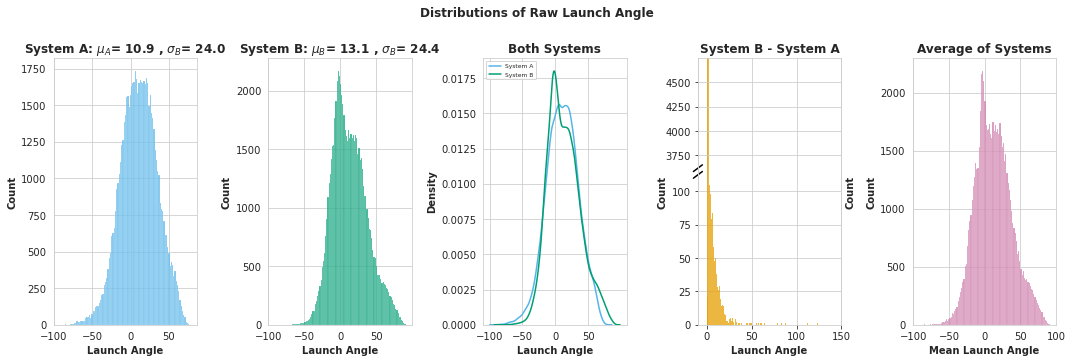

In [8]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,5)#,sharey=True)#sharex=True)
    fig.set_size_inches(15,5)
    fig.suptitle("Distributions of Raw Launch Angle",fontweight="bold",y=1)

    # Launch angle from system A
    sns.histplot(ax=ax[0],x=data.vangle_A,color=skyblue)
    ax[0].set_xticks(np.arange(-100,100,50))
    ax[0].set_xlabel("Launch Angle")
    ax[0].set_title("System A: " + r"$\mu_A$= {:.1f} , $\sigma_B$= {:.1f}".format(data.vangle_A.mean(), data.vangle_A.std()))

    # Launch angle from system B
    sns.histplot(ax=ax[1],x=data.vangle_B,color=green)
    ax[1].set_xticks(np.arange(-100,100,50))
    ax[1].set_xlabel("Launch Angle")
    ax[1].set_title("System B: " r"$\mu_B$= {:.1f} , $\sigma_B$= {:.1f}".format(data.vangle_B.mean(), data.vangle_B.std()))

    # KDE of both together
    sns.kdeplot(ax=ax[2],x=data.vangle_A,color=skyblue,fill=False,label="System A")
    sns.kdeplot(ax=ax[2],x=data.vangle_B,color=green,fill=False,label="System B")
    ax[2].set_xticks(np.arange(-100,100,50))
    ax[2].set_xlabel("Launch Angle")
    ax[2].legend(ncol=1,loc=2,frameon=True,fontsize=6)
    ax[2].set_title("Both Systems")

    # Difference of systems 
    data["vangle_diff"]  = np.abs(data.vangle_B-data.vangle_A)
    sns.histplot(ax=ax[3],x=data.query("vangle_diff > 0").vangle_diff,color=orange)
    ax[3].set_xlabel("Launch Angle")
    ax[3].set_title("System B - System A")
    
    # Very makeshift broken axis. Quick solution but not perfect
    # Make an axis copy so we can make the y-axis broken
    axcopy = ax[3].twinx()#fig.add_axes(ax[3].get_position())
    axcopy.yaxis.tick_left()
    sns.histplot(ax=axcopy,x=data.query("vangle_diff > 0").vangle_diff,color=orange)
    axcopy.spines.bottom.set_visible(False)
    ax[3].spines.top.set_visible(False)
    axcopy.xaxis.tick_top()
    axcopy.tick_params(labeltop=False)  # don't put tick labels at the top
    ax[3].xaxis.tick_bottom()
    ax[3].set_xlim(-10,150)
    ax[3].set_ylim(0,200)
    ax[3].set_yticks(np.arange(0,125,25))
    axcopy.set_ylim(2000,4750)
    axcopy.set_yticks(np.arange(3750,4750,250))
    ax[3].plot([-15,-5],[110,115],clip_on=False,color='k')
    ax[3].plot([-15,-5],[115,120],clip_on=False,color='k')

    # Linear average of system values
    sns.histplot(ax=ax[4],data=data[["vangle_A","vangle_B"]].mean(axis=1),color=pink)
    ax[4].set_xticks(np.arange(-100,150,50))
    ax[4].set_xlabel("Mean Launch Angle")
    ax[4].set_title("Average of Systems")

# Clean up
plt.tight_layout() 

From this figure we can see that System A shows a fairly normal distribution (maybe with a slighly heavier left tail) that is centered around $11^\circ$. We can see that system B produces a similar distribution with a mean of $13^\circ$, however, it seems as though the distribution may even be bimodal, with two peaks (around $0^\circ$ and $11^\circ$). We can see that the distributions are very similar (third panel) with the primary difference being in the shape of the tails and the dual peaks for system B.  In the far right, we can see the distribution of the difference of the two measurements (the y-axis has been broken to allow for visualization of the extreme values). From this we can see that the majority of the values are near zero; however, there are a fair number of values that are within a difference of $25^\circ$, with some values being as extreme as $100^\circ$ or more. Finally, one way we can resolve the issue of data mismatch is to simply take the average of the two values and use that as an estimate for the launch angle. This might not be the best solution but it is certainly an option. One thing to note is that because the data are on the interval $(-180^\circ , 180^\circ)$ we can just average the values without having to perform a circular mean. 


### Regression Analysis 

Another way to think about this is to perform a regression to check the slope. Two perfect systems would produce identical values resulting in a slope of 1. 

In [9]:
# Run regression using statsmodels and R style formulas
fml = 'vangle_B ~ vangle_A '

# Design matrices using patsy
y_train, X_train = dmatrices(fml, data, return_type='dataframe')

# Implement model
ols_model = sm.OLS(y_train, X_train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vangle_B   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 9.238e+05
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:09:30   Log-Likelihood:            -2.0303e+05
No. Observations:               64942   AIC:                         4.061e+05
Df Residuals:                   64940   BIC:                         4.061e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0068      0.024    126.510      0.000       2.960       3.053
vangle_A       0.8727      0.001    961.136      0.000       0.871       0.875
==============================================================================
Omnibus:                    88930.410   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40385223.458
Skew:                           7.750   Prob(JB):                         0.00
Kurtosis:                     124.180   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can perform a hypothesis test to determine if the slope is different from 1. 

In [10]:
print(ols_model.t_test('vangle_A = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8727      0.001   -140.137      0.000       0.871       0.875


Indeed this shows that the slope is statistically different from 1. We can visualze the values and see where the extreme instances are. 

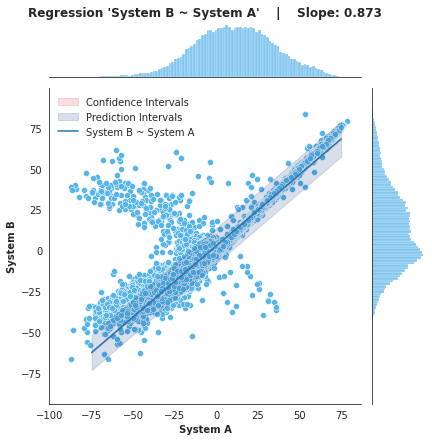

In [11]:
with sns.axes_style("white"):
    g = sns.JointGrid(data=data,x="vangle_A",y="vangle_B")
    g.plot(sns.scatterplot,sns.histplot,color=skyblue)
    g.set_axis_labels(xlabel="System A",ylabel="System B")


    # Plot Confidence and Prediction intervals of regression
    xvals=np.linspace(-75,75,1000)
    CI = ols_model.get_prediction(sm.add_constant(xvals)).summary_frame(alpha=0.05)
    g.ax_joint.fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=red,alpha=0.15,label="Confidence Intervals")
    g.ax_joint.fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    g.ax_joint.plot(xvals,ols_model.predict(sm.add_constant(xvals)),label="System B ~ System A")
    g.ax_joint.legend()

    # Add title
    g.ax_marg_x.set_title("Regression 'System B ~ System A'    |    Slope: {}".format(ols_model.params[1].round(3),fontweight="bold"))



Ultimately, all this does is confirm that the systems are not perfectly matched. We need to go beyond this to actually start thinking about player level data. 

## Exit Velocity

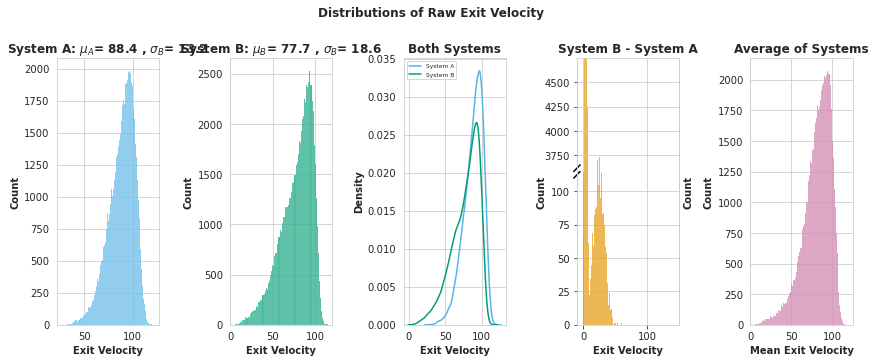

In [12]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,5)#,sharey=True)#sharex=True)
    fig.set_size_inches(12,5)
    fig.suptitle("Distributions of Raw Exit Velocity",fontweight="bold",y=1)

    # Launch angle from system A
    sns.histplot(ax=ax[0],x=data.speed_A,color=skyblue)
    ax[0].set_xlabel("Exit Velocity")
    ax[0].set_title("System A: " + r"$\mu_A$= {:.1f} , $\sigma_B$= {:.1f}".format(data.speed_A.mean(), data.speed_A.std()))

    # Launch angle from system B
    sns.histplot(ax=ax[1],x=data.speed_B,color=green)
    ax[1].set_xlabel("Exit Velocity")
    ax[1].set_title("System B: " r"$\mu_B$= {:.1f} , $\sigma_B$= {:.1f}".format(data.speed_B.mean(), data.speed_B.std()))

    # KDE of both together
    sns.kdeplot(ax=ax[2],x=data.speed_A,color=skyblue,fill=False,label="System A")
    sns.kdeplot(ax=ax[2],x=data.speed_B,color=green,fill=False,label="System B")
    ax[2].set_xlabel("Exit Velocity")
    ax[2].legend(ncol=1,loc=2,frameon=True,fontsize=6)
    ax[2].set_title("Both Systems")

    # Difference of systems 
    data["speed_diff"]  = np.abs(data.speed_B-data.speed_A)
    sns.histplot(ax=ax[3],x=data.query("speed_diff > 0").speed_diff,color=orange)
    ax[3].set_xlabel("Exit Velocity")
    ax[3].set_title("System B - System A")
    
    # Very makeshift broken axis. Quick solution but not perfect
    # Make an axis copy so we can make the y-axis broken
    axcopy = ax[3].twinx()#fig.add_axes(ax[3].get_position())
    axcopy.yaxis.tick_left()
    sns.histplot(ax=axcopy,x=data.query("speed_diff > 0").vangle_diff,color=orange)
    axcopy.spines.bottom.set_visible(False)
    ax[3].spines.top.set_visible(False)
    axcopy.xaxis.tick_top()
    axcopy.tick_params(labeltop=False)  # don't put tick labels at the top
    ax[3].xaxis.tick_bottom()
    ax[3].set_xlim(-10,150)
    ax[3].set_ylim(0,200)
    ax[3].set_yticks(np.arange(0,125,25))
    axcopy.set_ylim(2000,4750)
    axcopy.set_yticks(np.arange(3750,4750,250))
    ax[3].plot([-15,-5],[110,115],clip_on=False,color='k')
    ax[3].plot([-15,-5],[115,120],clip_on=False,color='k')

    # Linear average of system values
    sns.histplot(ax=ax[4],data=data[["speed_A","speed_B"]].mean(axis=1),color=pink)
    # ax[4].set_xticks(np.arange(-100,150,50))
    ax[4].set_xlim(0,125)
    ax[4].set_xlabel("Mean Exit Velocity")
    ax[4].set_title("Average of Systems")
# Clean up
plt.tight_layout() 

Many of the observations made for the launch angle data are similar for the exit velocity data, but there are a few interesting differences worth pointing out. First, the distributions have a simlar shape visually, but the overlaid kernel density estimate (KDE) plots show that the system A has a much tighter distributions, whereas system B is a bit wider on the left side. Interestingly, when we compute the difference of the two we see that there is a fairly large peak around $25$-mph (as a reminder, the y-axis is broken for visualization). Lastly, we can just take the average and see what the distribution looks like (far right).


### Regression Analysis
Let's see how the values from the two systems compare.

In [13]:
# Run regression using statsmodels and R style formulas
fml = 'speed_B ~ speed_A '

# Design matrices using patsy
y_train, X_train = dmatrices(fml, data, return_type='dataframe')

# Implement model
ols_model = sm.OLS(y_train, X_train).fit()
print(ols_model.summary())

print(ols_model.t_test('speed_A = 1'))


                            OLS Regression Results                            
Dep. Variable:                speed_B   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                 1.301e+05
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:09:38   Log-Likelihood:            -2.4043e+05
No. Observations:               64942   AIC:                         4.809e+05
Df Residuals:                   64940   BIC:                         4.809e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7345      0.262    -52.367      0.0

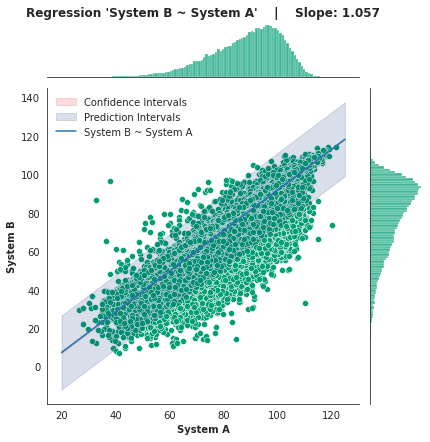

In [14]:
with sns.axes_style("white"):
    g = sns.JointGrid(data=data,x="speed_A",y="speed_B")
    g.plot(sns.scatterplot,sns.histplot,color=green)
    g.set_axis_labels(xlabel="System A",ylabel="System B")

    # Plot Confidence and Prediction intervals of regression
    xvals=np.linspace(20,125,1000)
    CI = ols_model.get_prediction(sm.add_constant(xvals)).summary_frame(alpha=0.05)
    g.ax_joint.fill_between(xvals,CI.mean_ci_lower.to_numpy(),CI.mean_ci_upper.to_numpy(),color=red,alpha=0.15,label="Confidence Intervals")
    g.ax_joint.fill_between(xvals,CI.obs_ci_lower.to_numpy(),CI.obs_ci_upper.to_numpy(),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    g.ax_joint.plot(xvals,ols_model.predict(sm.add_constant(xvals)),label="System B ~ System A")
    g.ax_joint.legend(loc=2)

    # Add title
    g.ax_marg_x.set_title("Regression 'System B ~ System A'    |    Slope: {}".format(ols_model.params[1].round(3),fontweight="bold"))



# Modeling Exit Velocity 

What we really want to know is what is the expectation of a player's exit velocity given these noisy measurements. One simple way to start is to simply performing a linear regression to see the relationship between `exit velocity` and `launch angle`. This is by no means a new thing, but it is a place to start. 

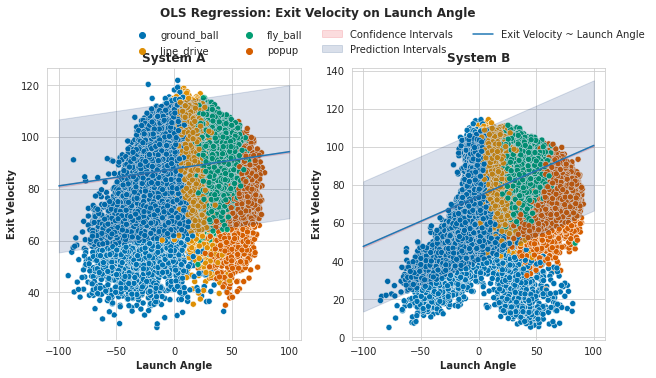

In [15]:
def regression(fml, data):
    # Design matrices using patsy
    y_train, X_train = dmatrices(fml, data, return_type='dataframe')
    # Implement model
    ols_model = sm.OLS(y_train, X_train).fit()
    return ols_model


with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(1,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,5)
    
    # ------------------------- #
    #          System A         #
    # ------------------------- #

    sns.scatterplot(ax=ax[0],data=data, x="vangle_A", y="speed_A",hue="hittype",legend=False,palette="colorblind")
    # Run regression using statsmodels and R style formulas
    modelA = regression('speed_A ~ vangle_A',data)

    # Plot Confidence and Prediction intervals of regression
    xvals=np.linspace(-100,100,1000)
    CI_A = modelA.get_prediction(sm.add_constant(xvals)).summary_frame(alpha=0.05)
    ax[0].fill_between(xvals,CI_A.mean_ci_lower.to_numpy(),CI_A.mean_ci_upper.to_numpy(),color=red,alpha=0.15,label="Confidence Intervals")
    ax[0].fill_between(xvals,CI_A.obs_ci_lower.to_numpy(),CI_A.obs_ci_upper.to_numpy(),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[0].plot(xvals,modelA.predict(sm.add_constant(xvals)),label="Exit Velocity (A) ~ Launch Angle (A)")
    ax[0].set(xlabel='Launch Angle', ylabel='Exit Velocity',title='System A')
    # ax[0].legend(loc=2)

    # ------------------------- #
    #          System B         #
    # ------------------------- #
    
    sns.scatterplot(ax=ax[1],data=data, x="vangle_B", y="speed_B",hue="hittype",palette="colorblind")#,color=green)

    # Run regression using statsmodels and R style formulas
    modelB = regression('speed_B ~ vangle_B',data)

    # Plot Confidence and Prediction intervals of regression
    xvals=np.linspace(-100,100,1000)
    CI_B = modelB.get_prediction(sm.add_constant(xvals)).summary_frame(alpha=0.05)
    ax[1].fill_between(xvals,CI_B.mean_ci_lower.to_numpy(),CI_B.mean_ci_upper.to_numpy(),color=red,alpha=0.15,label="Confidence Intervals")
    ax[1].fill_between(xvals,CI_B.obs_ci_lower.to_numpy(),CI_B.obs_ci_upper.to_numpy(),color=blue,alpha=0.15,label="Prediction Intervals")

    # Plot regression
    ax[1].plot(xvals,modelB.predict(sm.add_constant(xvals)),label="Exit Velocity ~ Launch Angle")
    ax[1].legend(loc=2,ncol=4,bbox_to_anchor=(-.9,1.175))
    ax[1].set(xlabel='Launch Angle', ylabel='Exit Velocity',title='System B')

    # Figure title
    fig.suptitle("OLS Regression: Exit Velocity on Launch Angle",fontweight="bold",y=1.05)
    

Clearly this does not look great. We know that different outcomes have very different properties, so it is easy to see that for each hit type there wold be a diferent regression line. 

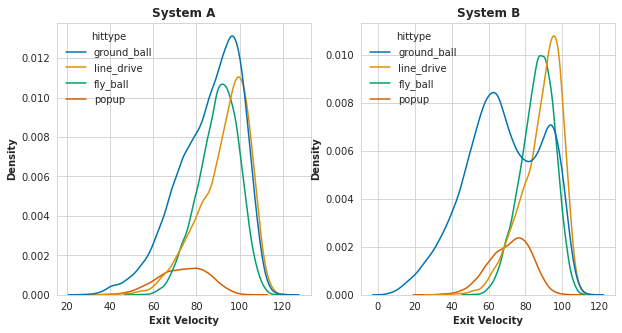

In [16]:
with sns.axes_style('whitegrid'):
    # Make figure
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    sns.kdeplot(ax=ax[0],data=data,x="speed_A",hue="hittype",palette="colorblind")
    ax[0].set(xlabel="Exit Velocity",title="System A")
    sns.kdeplot(ax=ax[1],data=data,x="speed_B",hue="hittype",palette="colorblind")
    ax[1].set(xlabel="Exit Velocity",title="System B")


We can see the regression as well. These are not the nicest figures but its quick and dirty to show the idea. 

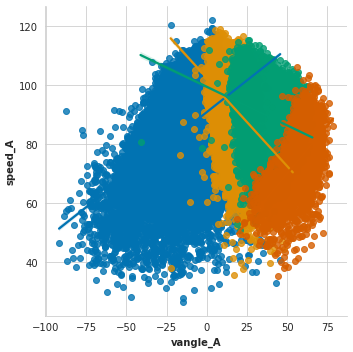

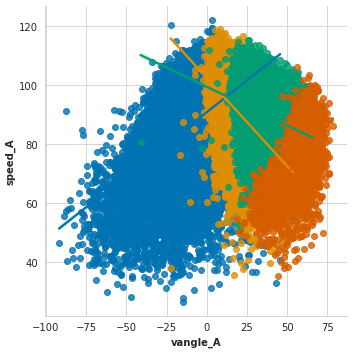

In [17]:
with sns.axes_style("whitegrid"):
    
    # ------------------------- #
    #          System A         #
    # ------------------------- #
    sns.lmplot(data=data, x="vangle_A", y="speed_A",hue="hittype",legend=False,palette="colorblind")

    # ------------------------- #
    #          System B         #
    # ------------------------- #
    sns.lmplot(data=data, x="vangle_A", y="speed_A",hue="hittype",legend=False,palette="colorblind")


We can see that from these figures alone, modeling the behavior using launch angle and exit velocity together might not be the most informative. 

Nonetheless, since what we really care about is each individual batter's average exit velocity, let's start by simply aggregating the data for each player.

In [18]:
# Select 10 random players
random_batters = np.random.choice(data.batter,10)

In [19]:
# Group by batter
grouped = data.groupby(by="batter")

/Users/justinbrantley/miniconda3/envs/pymc_env/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


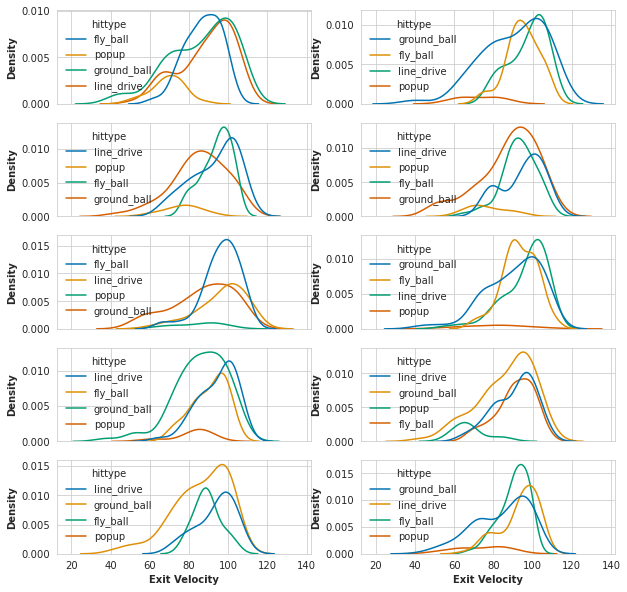

In [20]:
with sns.axes_style('whitegrid'):
    # Make figure
    fig, ax = plt.subplots(5,2,sharex=True)
    fig.set_size_inches(10,10)
    for (thisax,batter) in zip(ax.ravel(),random_batters):
        thisgroup = grouped.get_group(batter)
        sns.kdeplot(ax=thisax,data=thisgroup,x="speed_A",hue="hittype",palette="colorblind")
        thisax.set(xlabel="Exit Velocity")

Interestingly, from this we can see that while the distributions do vary, there is some amount of similarity in the distribution means for a single player. Let's look at the mean and standard deviation for all the players. 

In [51]:
# bdA = grouped.speed_A.agg(["mean","std"]).reset_index().sort_values(by="mean",ascending=False)
# bdB = grouped.speed_B.agg(["mean","std"]).reset_index().sort_values(by="mean",ascending=False)
bd = data.groupby(by=["batter"]).agg({"speed_A":["mean","std"],"speed_B":["mean","std"]})#.rename(columns={"mean":"speed_A_mean","std":"speed_A_mean"}).reset_index()# data.speed_A.mean(), data.speed_A.var()
bd.columns = bd.columns.map("_".join)
bd

,speed_A_mean,speed_A_std,speed_B_mean,speed_B_std
batter,,,,
1,89.231646,8.511647,77.007720,15.106317
2,81.072924,15.032587,61.125150,23.976237
3,92.482074,11.076118,77.958440,8.539720
4,89.839477,13.664058,77.946913,20.377982
5,88.834383,12.803181,78.832379,17.710478
...,...,...,...,...
812,91.997300,16.354419,81.430736,20.155885
813,93.012396,15.683194,80.662619,28.121658
814,94.928281,9.055372,72.564050,24.055477


Let's see how many plate appearances we have for each batter.

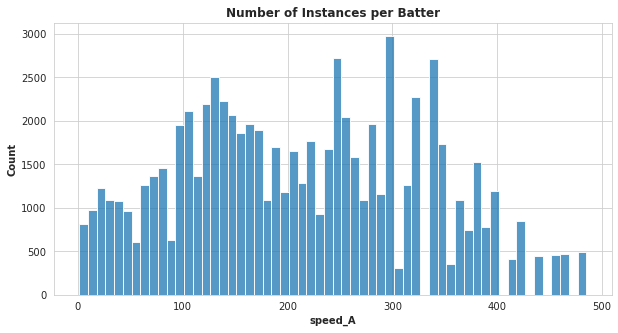

In [52]:
# How many in each group
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    sns.histplot(grouped.speed_A.transform(lambda x: len(x)))
    ax.set(title="Number of Instances per Batter")

Here we will look at the mean exit velocity $\pm$ standard deviation for each batter, with one figure for each sensor.

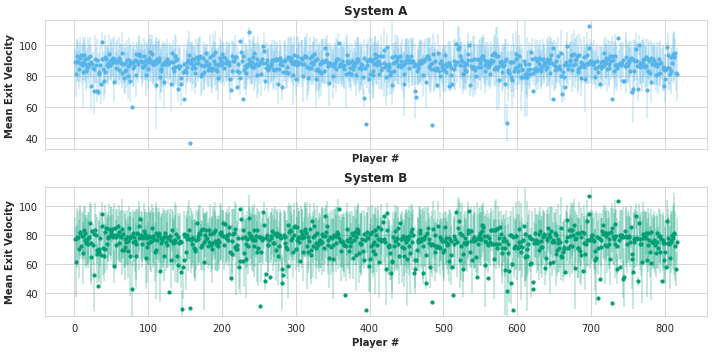

In [53]:
# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2,1,sharex=True)
    fig.set_size_inches(10,5)
    
    # System A
    markers, caps, bars = ax[0].errorbar(x=bd.index,y=bd["speed_A_mean"],markersize=1,yerr=bd["speed_A_std"],color=skyblue,fmt='o',zorder=1)
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    ax[0].scatter(x=bd.index,y=bd["speed_A_mean"],s=10,color=skyblue,zorder=2)
    ax[0].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System A")
    
    # System B
    markers, caps, bars = ax[1].errorbar(x=bd.index,y=bd["speed_B_mean"],markersize=1,yerr=bd["speed_B_std"],color=green,fmt='o',zorder=1)
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    ax[1].scatter(x=bd.index,y=bd["speed_B_mean"],s=10,color=green,zorder=2)
    ax[1].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System B")

    # Clean up
    plt.tight_layout()

## Modeling Player Specific Exit Velocity

One thing we can do is build a player specific model that regresses exit velocity on launch angle


In [54]:
# Run regression using statsmodels and R style formulas
fml = 'speed_A ~ vangle_A + C(batter)'

# Design matrices using patsy
y_train, X_train = dmatrices(fml, data, return_type='dataframe')

# Implement model
ols_model1A = sm.OLS(y_train, X_train).fit()
# print(ols_model1A.summary())
print("Summary is printed at the end of the notebook since the output is long.")

Summary is printed at the end of the notebook since the output is long.


So now we have a model for each batter that tells us the relationship between launch angle and exit velocity for each player. If we want to get even more complicated, we can build a model for each player for each outcome. 

In [55]:
# Run regression using statsmodels and R style formulas
fml = 'speed_A ~ vangle_A + C(batter)*C(hittype)'

# Design matrices using patsy
y_train, X_train = dmatrices(fml, data, return_type='dataframe')

# Implement model
ols_model2A = sm.OLS(y_train, X_train).fit()
# print(ols_model2A.summary())
print("Summary is printed at the end of the notebook since the output is long.")


Summary is printed at the end of the notebook since the output is long.


So now we can estimate the relationship between launch angle and exit velocity for a player and hit type. In reality, this is only moderatey informative given that exit velocity, launch angle, and hit type are all batting outcomes. In order to make use of this model, we would need to estimate the probability of each hit type and the average launch angle for each batter to estimate the average exit velocity. Unfortunately, this may be difficult or impossible if don't have enough data for each player. 

### Regression to the mean

Let's go back to basics and regress each player's exit velocity to the mean. Given that we can estimate the mean and variance of each player's exit velocity distribution, this should provide us with a reliable player estimate. For eacy system, we will compute:

\begin{align*}
\mu_{\text{new}} & = \frac{\mu_{total} / \sigma^2_{total} + \mu_{batter} / \sigma^2_{batter}}{1 / \sigma^2_{total} + 1 / \sigma^2_{batter}}
\end{align*}


In [56]:
# Note: we fill nan values here with a large value so that we can compute the regressed mean for batter's with only one instance. In this case we have a super large
# standard deviation for the data which means the regression --> mean should basically be the overall mean.
bd = bd.fillna(1_000_000)
bd["regressed_mean_A"] = bd.apply(lambda row: (row["speed_A_mean"]/(row["speed_A_std"]**2) + data.speed_A.mean()/data.speed_A.var()) / (1/(row["speed_A_std"]**2)  +  1/data.speed_A.var()),axis=1)
bd["regressed_mean_B"] = bd.apply(lambda row: (row["speed_B_mean"]/(row["speed_B_std"]**2) + data.speed_B.mean()/data.speed_B.var()) / (1/(row["speed_B_std"]**2)  +  1/data.speed_B.var()),axis=1)
bd[bd == 1_000_000] = pd.NA
bd.head()

,speed_A_mean,speed_A_std,speed_B_mean,speed_B_std,regressed_mean_A,regressed_mean_B
batter,,,,,,
1,89.231646,8.511647,77.007720,15.106317,88.994677,77.301659
2,81.072924,15.032587,61.125150,23.976237,85.226300,71.493783
3,92.482074,11.076118,77.958440,8.539720,90.804898,77.921928
4,89.839477,13.664058,77.946913,20.377982,89.107626,77.838689
5,88.834383,12.803181,78.832379,17.710478,88.636005,78.317517


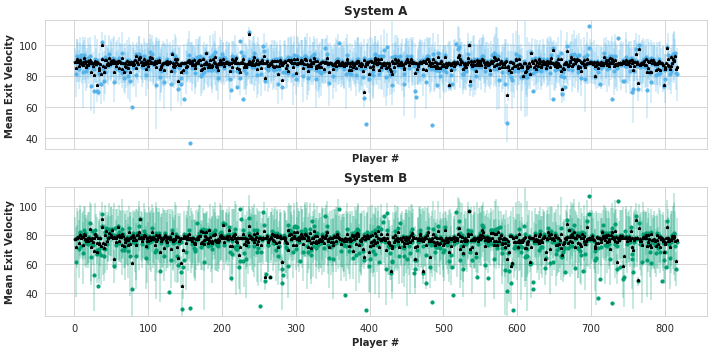

In [57]:
# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(2,1,sharex=True)
    fig.set_size_inches(10,5)
    
    # System A
    markers, caps, bars = ax[0].errorbar(x=bd.index,y=bd["speed_A_mean"],markersize=1,yerr=bd["speed_A_std"],color=skyblue,fmt='o',zorder=1)
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    ax[0].scatter(x=bd.index,y=bd["speed_A_mean"],s=10,color=skyblue,zorder=2)
    ax[0].scatter(x=bd.index,y=bd["regressed_mean_A"],s=8,color="k",marker="*",zorder=2)
    ax[0].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System A")
    
    # System B
    markers, caps, bars = ax[1].errorbar(x=bd.index,y=bd["speed_B_mean"],markersize=1,yerr=bd["speed_B_std"],color=green,fmt='o',zorder=1)
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    ax[1].scatter(x=bd.index,y=bd["speed_B_mean"],s=10,color=green,zorder=2)
    ax[1].scatter(x=bd.index,y=bd["regressed_mean_B"],s=8,color="k",marker="*",zorder=2)
    ax[1].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System B")

    # Clean up
    plt.tight_layout()
    

From here we can see that the majority of values live around the $80-90$ mph range, depending on which system is being used. From here we could get another naive estimate by simply averagng the values. Let's look at our random players.

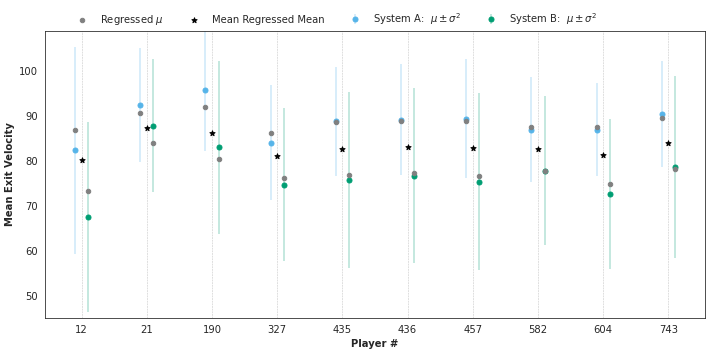

In [58]:
# Get data for random batters
_local = bd.iloc[random_batters,:].reset_index().sort_values(by="batter").reset_index().copy()

# Make figure
with sns.axes_style("white"):
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot()
    
    for ii in _local.index:
        ax.axvline(ii,linewidth=.5,color=grey,linestyle='--',alpha=.5)

    # System A
    markers, caps, bars = ax.errorbar(x=_local.index-.1,y=_local["speed_A_mean"],markersize=5,yerr=_local["speed_A_std"],color=skyblue,fmt='o',zorder=1,label=r"System A:  $\mu \pm \sigma^2$")
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    # ax.scatter(x=_local.index-.1,y=_local["speed_A_mean"],s=20,color=skyblue,zorder=2)
    ax.scatter(x=_local.index-.1,y=_local["regressed_mean_A"],s=20,color=grey,marker="o",zorder=2)#,label=r"Regressed $\mu$")
    # ax[0].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System A")
    
    # System B
    markers, caps, bars = ax.errorbar(x=_local.index+.1,y=_local["speed_B_mean"],markersize=5,yerr=_local["speed_B_std"],color=green,fmt='o',zorder=1,label=r"System B:  $\mu \pm \sigma^2$")
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    # ax.scatter(x=_local.index+.1,y=_local["speed_B_mean"],s=20,color=green,zorder=2,label="System B Mean")
    ax.scatter(x=_local.index+.1,y=_local["regressed_mean_B"],s=20,color=grey,marker="o",zorder=2,label=r"Regressed $\mu$")
    # ax[1].set(xlabel="Player #", ylabel="Mean Exit Velocity",title="System B")

    # System averages
    ax.scatter(x=_local.index,y=_local[["regressed_mean_A","regressed_mean_B"]].mean(axis=1),s=30,color="k",marker="*",zorder=2,label="Mean Regressed Mean")
    ax.legend(ncol=6,loc=1,bbox_to_anchor=(.85,1.1),fontsize=10)
    # Clean up
    ax.set(xlabel="Player #", ylabel="Mean Exit Velocity",ylim=(45,109),xticks=_local.index,xticklabels=list(map(str,_local.batter)))
    plt.tight_layout()

While this is a very naive estimate it is interesting to see how the new mean estimates are shrunken to account for the variability in each system. 

## Modeling Player Specific Exit Velocity Based on Hit Types

In the previous sections we developed two models for exit velocity. One is a regression model that gives us an estimate exit velocity for a given launch angle. This could be an interesting thing to consider when looking at a player's swing behavior, but for the simple exercise of computing an average exit velocity, it's not really that informative. The second model is a basic regression to the mean that shrinks all of the observed means towards the group mean. We then averaged the two sensors to get an average of averages. In reality, we would likely be better off to weight each system measurement based on how certain we are about each. We could try to do this quantitatively or we could simply choose weights based on intuition. 

### Hit Types

A more interesting, and likely useful, approach is model the relationship between hit types and average exit velocity. There is definitely a correlation between launch angle and hit type, but it may be a bit more distant for exit velocity. However, general league knowledge tells us that a ball hit at ~$100$ mph with a launch angle of ~$25^{\circ}$ is likely to result in a homerun. Yet, some power hitters, like Giancarlo Stanton, hit the ball so hard that they are able to hit home runs with a much lower launch angle, around $15^{\circ}$. 

Let's setup the data to check this out.

In [59]:
# hd == hit data
hd = pd.concat([data.groupby(by=["batter","hittype"]).size().unstack(fill_value=0),
               data.groupby(by=["batter"]).agg({"speed_A":"mean","vangle_A":"mean","speed_B":"mean","vangle_B":"mean"})]
               ,axis=1
               )
hd.head()

,fly_ball,ground_ball,line_drive,popup,speed_A,vangle_A,speed_B,vangle_B
batter,,,,,,,,
1,18,41,18,3,89.231646,9.396592,77.007720,11.101974
2,2,13,2,3,81.072924,4.614494,61.125150,15.039281
3,3,5,0,1,92.482074,9.745586,77.958440,16.339697
4,28,70,38,9,89.839477,10.062538,77.946913,12.837871
5,19,50,25,14,88.834383,11.434604,78.832379,15.861496


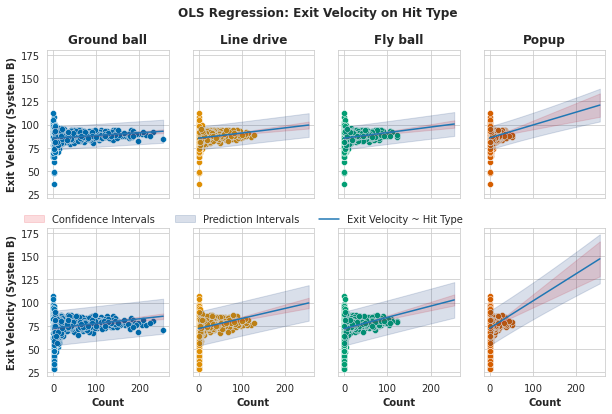

In [60]:
def regression(fml, data):
    # Design matrices using patsy
    y_train, X_train = dmatrices(fml, data, return_type='dataframe')
    # Implement model
    ols_model = sm.OLS(y_train, X_train).fit()
    return ols_model

def plot_regression(ax,model,label=[],xvals=np.linspace(-100,100,1000)):
    # Get confidence/prediction intervals
    CI_A = model.get_prediction(sm.add_constant(xvals)).summary_frame(alpha=0.05)
    # Add to plot
    ax.fill_between(xvals,CI_A.mean_ci_lower.to_numpy(),CI_A.mean_ci_upper.to_numpy(),color=red,alpha=0.15,label="Confidence Intervals")
    ax.fill_between(xvals,CI_A.obs_ci_lower.to_numpy(),CI_A.obs_ci_upper.to_numpy(),color=blue,alpha=0.15,label="Prediction Intervals")
    # Plot regression
    ax.plot(xvals,model.predict(sm.add_constant(xvals)),label="Exit Velocity ~ Hit Type")

with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(2,4,sharey=True,sharex=True)
    fig.set_size_inches(10,6)
    
    xvals = np.linspace(-1,hd[data.hittype.unique().tolist()].max()[0],1000)
    
    # ------------------------- #
    #          System A         #
    # ------------------------- #

    for ii,(hittype,clr) in enumerate(zip(data.hittype.unique(),[clr for clr in sns.color_palette("colorblind",n_colors=4).as_hex()])):
        sns.scatterplot(ax=ax[0,ii],data=hd, x=hittype, y="speed_A",color=clr)
        # Run regression using statsmodels and R style formulas
        fml = 'speed_A ~ {}'.format(hittype)
        model = regression(fml,hd)
        plot_regression(ax[0,ii],model,label=fml,xvals=xvals)
        ax[0,ii].set(xlabel='Count', ylabel='Exit Velocity (System B)',title=(" ").join(hittype.split('_')).capitalize())

    # ------------------------- #
    #          System B         #
    # ------------------------- #

    for ii,(hittype,clr) in enumerate(zip(data.hittype.unique(),[clr for clr in sns.color_palette("colorblind",n_colors=4).as_hex()])):
            sns.scatterplot(ax=ax[1,ii],data=hd, x=hittype, y="speed_B",color=clr)
            # Run regression using statsmodels and R style formulas
            fml = 'speed_B ~ {}'.format(hittype)
            model = regression(fml,hd)
            plot_regression(ax[1,ii],model,label=fml,xvals=xvals)
            ax[1,ii].set(xlabel='Count', ylabel='Exit Velocity (System B)')#,title=(" ").join(hittype.split('_')).capitalize())


    ax[1,2].legend(loc=1,ncol=3,bbox_to_anchor=(1.1,1.15))


    # Figure title
    fig.suptitle("OLS Regression: Exit Velocity on Hit Type",fontweight="bold")

This figure is not really the model that we want but it is an interesting visualization of the slight relationship between the number of hits for each hittype and the average exit velocity. What we really need is a multiple regression model to account for all the hit types in a single model. 

We are just going to focus on system A for now. Despite having less data, if we think it is more trustworthy we will proceed with this system. We can do the same process we are proposing for system B. 

In [61]:
"speed_A ~ " +  " + ".join(data.hittype.unique().tolist())

'speed_A ~ ground_ball + line_drive + fly_ball + popup'

In [62]:
# Run regression using statsmodels and R style formulas
fml = 'speed_A ~ ' +  ' + '.join(data.hittype.unique().tolist())

# Design matrices using patsy
hd["speed_A_unfilledna"] = hd["speed_A"]
hd["speed_A"] = hd["speed_A"].fillna(0)
y_train, X_train = dmatrices(fml, hd, return_type='dataframe')

# Implement model
ols_model_hittype = sm.OLS(y_train, X_train).fit()
# print(ols_model_hittype.summary())

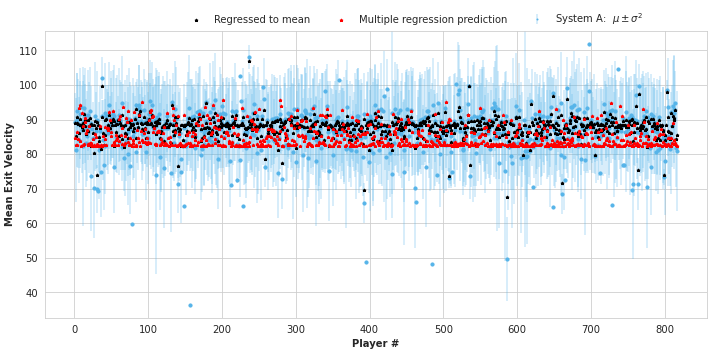

In [63]:
# nd ~ new data
nd = pd.concat([hd,bd],axis=1)
predictA = ols_model_hittype.get_prediction(X_train).summary_frame()

# Make figure
with plt.rc_context({"font.size" : 10}):
    with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot()
        
        # System A
        markers, caps, bars = ax.errorbar(x=nd.index,y=nd["speed_A_mean"],markersize=1,yerr=nd["speed_A_std"],color=skyblue,fmt='o',zorder=1,label= r"System A:  $\mu \pm \sigma^2$")
        [bar.set_alpha(0.3) for bar in bars]
        [cap.set_alpha(0.3) for cap in caps]
        ax.scatter(x=nd.index,y=nd["speed_A_mean"],s=10,color=skyblue,zorder=2)
        ax.scatter(x=nd.index,y=nd["regressed_mean_A"],s=8,color="k",marker="*",zorder=2,label="Regressed to mean")
        ax.scatter(x=predictA.index,y=predictA["mean"],s=8,color="r",marker="*",zorder=2,label="Multiple regression prediction")
        ax.set(xlabel="Player #", ylabel="Mean Exit Velocity")#,title="System A")
        ax.legend(ncol=3,loc=2,bbox_to_anchor=(.2,1.1))

        # Clean up
        plt.tight_layout()

This is pretty interesting, but we can can clearly see there is an issue. The lower bound of the predictions is approximately the mean of ~$85$-mph for System A. This makes sense if we just look at the regression model. The intercept is $85.5$, meaning that the count of each hit have the effect of pulling this value up or down. However, the coefficients are pretty small so the 'pulling' effect is going to be small, particularly from the negative coefficients. Additionally, if a player has zero hits of a hit type, that will have no impact on the model. So how do we resolve this issue to better estimate the true exit velocity using the number o hits per hit type. 

### Modeling the average number of hits per type

One thing we can do is assume that an average player with a sufficient number of at-bats is going to have an approximate distribution of each hit type. That is going to vary across players, but the more samples we get the better our estimate of true probability per hit type. On the other hand, our estimate is heavily biased for players with few instances of each hit type. 

#### Dirichlet-Multinomial

We will model our counts of hit types with a multinomial distribution and the probability of each using the Dirichlet. 

In [64]:
nd["hit_total"] = nd[data.hittype.unique()].sum(axis=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


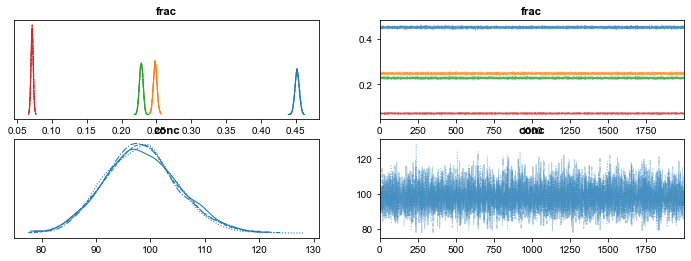

In [65]:
import pymc as pm
import arviz as az

# Get data as numpy array 
_local = nd.loc[nd.hit_total > 20,:].copy()
counts = _local[data.hittype.unique()].to_numpy()

# This is a reparamerization of the Dirichlet-Multinomial
with pm.Model() as model:
    frac = pm.Dirichlet("frac", a=np.ones(len(data.hittype.unique())))
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial("counts", a=frac*conc,n=counts.sum(1),shape=counts.shape, observed=counts)
    trace = pm.sample(2000, chains=4, return_inferencedata=True)

    az.plot_trace(data=trace, var_names=["frac", "conc"])

    alpha = trace["posterior"]["frac"].mean(("chain","draw")).to_numpy() * trace["posterior"]["conc"].mean(("chain","draw")).to_numpy()

    # Save beta parameters
    with open("./dirichletmultinomial_params.npy","wb") as f:
        np.save(f,alpha)


So now we have a base number of each hit type that we can use for estimating a player's true exit velocity from the adjusted number of hit types. 

In [66]:
print("Base number of hits:")
print("------------------- ")
for (hit,alphaval) in zip(data.hittype.unique(),alpha):
    print((" ").join(hit.split('_')).capitalize() + ": {}".format(int(alphaval)))

Base number of hits:
------------------- 
Ground ball: 44
Line drive: 24
Fly ball: 22
Popup: 7


In [67]:
nd = pd.concat([nd,round(nd[data.hittype.unique()]+ alpha).add_suffix("_eb")],axis=1)
nd.head()

,fly_ball,ground_ball,line_drive,popup,speed_A,vangle_A,speed_B,vangle_B,speed_A_unfilledna,speed_A_mean,speed_A_std,speed_B_mean,speed_B_std,regressed_mean_A,regressed_mean_B,hit_total,ground_ball_eb,line_drive_eb,fly_ball_eb,popup_eb
batter,,,,,,,,,,,,,,,,,,,,
1,18,41,18,3,89.231646,9.396592,77.007720,11.101974,89.231646,89.231646,8.511647,77.007720,15.106317,88.994677,77.301659,80,85.0,42.0,40.0,10.0
2,2,13,2,3,81.072924,4.614494,61.125150,15.039281,81.072924,81.072924,15.032587,61.125150,23.976237,85.226300,71.493783,20,57.0,26.0,24.0,10.0
3,3,5,0,1,92.482074,9.745586,77.958440,16.339697,92.482074,92.482074,11.076118,77.958440,8.539720,90.804898,77.921928,9,49.0,24.0,25.0,8.0
4,28,70,38,9,89.839477,10.062538,77.946913,12.837871,89.839477,89.839477,13.664058,77.946913,20.377982,89.107626,77.838689,145,114.0,62.0,50.0,16.0
5,19,50,25,14,88.834383,11.434604,78.832379,15.861496,88.834383,88.834383,12.803181,78.832379,17.710478,88.636005,78.317517,108,94.0,49.0,41.0,21.0


In [68]:
'speed_A ~ ' +  ' + '.join([val + "_eb" for val in data.hittype.unique().tolist()])

'speed_A ~ ground_ball_eb + line_drive_eb + fly_ball_eb + popup_eb'

In [69]:
# Run regression using statsmodels and R style formulas
fml = 'speed_A ~ ' +  ' + '.join([val + "_eb" for val in data.hittype.unique().tolist()])

# Design matrices using patsy
y_traineb, X_traineb = dmatrices(fml, nd, return_type='dataframe')

# Implement model
ols_model_hittype_eb = sm.OLS(y_traineb, X_traineb).fit()
# print(ols_model_hittype_eb.summary())

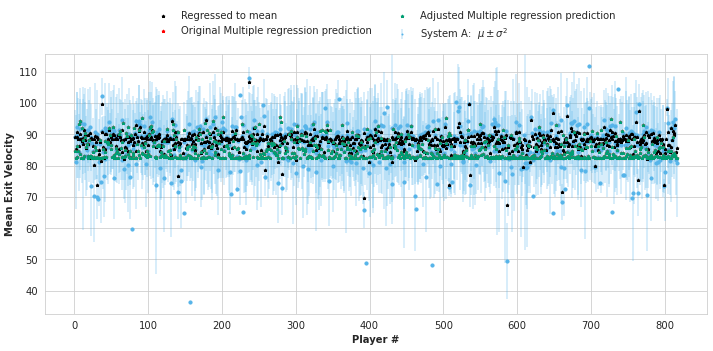

In [70]:
# nd ~ new data
# nd = pd.concat([hd,bd],axis=1)
predictA = ols_model_hittype.get_prediction(X_train).summary_frame()
predictA_eb = ols_model_hittype_eb.get_prediction(X_traineb).summary_frame()

# Make figure
with plt.rc_context({"font.size" : 10}):
    with sns.axes_style("whitegrid"):
        fig = plt.figure(figsize=(10,5))
        ax = fig.add_subplot()
        
        # System A
        markers, caps, bars = ax.errorbar(x=nd.index,y=nd["speed_A_mean"],markersize=1,yerr=nd["speed_A_std"],color=skyblue,fmt='o',zorder=1,label= r"System A:  $\mu \pm \sigma^2$")
        [bar.set_alpha(0.3) for bar in bars]
        [cap.set_alpha(0.3) for cap in caps]
        ax.scatter(x=nd.index,y=nd["speed_A_mean"],s=10,color=skyblue,zorder=2)
        ax.scatter(x=nd.index,y=nd["regressed_mean_A"],s=8,color="k",marker="*",zorder=2,label="Regressed to mean")
        ax.scatter(x=predictA.index,y=predictA["mean"],s=8,color="r",marker="*",zorder=2,label="Original Multiple regression prediction")
        ax.scatter(x=predictA_eb.index,y=predictA_eb["mean"],s=8,color=green,marker="*",zorder=2,label="Adjusted Multiple regression prediction")
        ax.set(xlabel="Player #", ylabel="Mean Exit Velocity")#,title="System A")
        ax.legend(ncol=2,loc=2,bbox_to_anchor=(0.15,1.2))

        # Clean up
        plt.tight_layout()

It turns out that by biasing our estimate for base rate of each hit type we shrink the estimates even more. This is not surpising since this is essentially exactly what this is supposed to do. For people with fewer observations we bias them towards the mean. For those with more observations, the likelihood has the ability to pull the data away from the prior if the evidence is sufficient to do so. Here we can see the above figure for varying ranges of plate appearances.

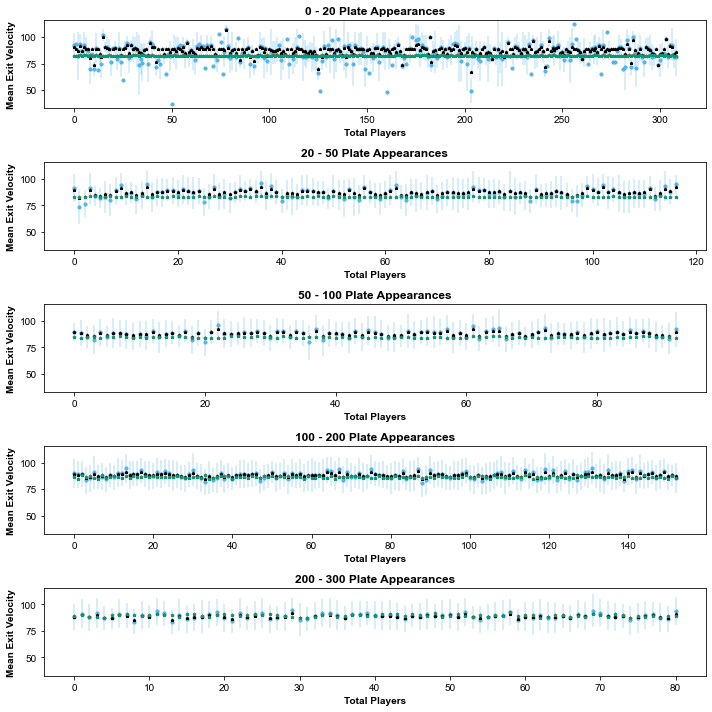

In [71]:
# Make figure
num_PAs = [0,20,50,100,200,300]
fig, ax = plt.subplots(len(num_PAs)-1,sharey=True)
fig.set_size_inches(10,10)

# Increase min number of plate appearances for each subplot
with sns.axes_style("whitegrid"):
    with plt.rc_context({"font.size" : 10}):
        for ii,thisax in enumerate(ax.ravel()):
            # which_batters = nd.loc[nd.hit_total > PA,:].index.tolist()
            
            # System A
            _local = nd.loc[(nd.hit_total > num_PAs[ii]) & (nd.hit_total < num_PAs[ii+1]),:]#.reset_index()

            markers, caps, bars = thisax.errorbar(x=_local.reset_index().index,y=_local["speed_A_mean"],markersize=1,yerr=_local["speed_A_std"],color=skyblue,fmt='o',zorder=1,label= r"System A:  $\mu \pm \sigma^2$")
            [bar.set_alpha(0.3) for bar in bars]
            [cap.set_alpha(0.3) for cap in caps]
            thisax.scatter(x=_local.reset_index().index,y=_local["speed_A_mean"],s=10,color=skyblue,zorder=2)
            thisax.scatter(x=_local.reset_index().index,y=_local["regressed_mean_A"],s=8,color="k",marker="*",zorder=2,label="Regressed to mean")

            thisax.scatter(x=predictA.loc[_local.index,:].reset_index().index,y=predictA.loc[_local.index,"mean"],s=8,color="r",marker="*",zorder=2,label="Original Multiple regression prediction")
            thisax.scatter(x=predictA_eb.loc[_local.index,:].reset_index().index,y=predictA_eb.loc[_local.index,"mean"],s=8,color=green,marker="*",zorder=2,label="Adjusted Multiple regression prediction")
            thisax.set(xlabel="Total Players", ylabel="Mean Exit Velocity",title="{} - {} Plate Appearances".format(num_PAs[ii],num_PAs[ii+1]))
            # ax.legend(ncol=2,loc=2,bbox_to_anchor=(0.15,1.2))

            # Clean up
            plt.tight_layout()


One thing to notice is that as the number of plate appearances goes up, the standard deviation on the observed data for the that batter decreases. That is completely expected. We can also see that the effects of the shrinkage techniques seem to have a slightly lower impact than on individuals with fewer appearances. For example, for those with fewer than 20, their estimate is nearly exactly the base rate estimate from the emperical Bayes shrinkage. For the second lowest group, the means begin to separate, where the value regressed to the mean based on the mean and standard deviation of the values is usually the highest value, while the shurnken estimate tends to be the lowest, except in the case the raw data is lower. For the range with the highest number of plate appearances, the regression approach tends to overestimate the values for all players, while the shrunken estimate is generally in between the raw value and the raw value regressed towards the mean. Quite interestingly, in most cases the average exit velocity per player sits right around $85$-$90$-mph.

# Conclusions

In this notebook, we started by looking at the overall distributions of the launch angle and exit velocity data from the two measurement systems. We observed some slight differences in the data and then considered how each system compared to one another. We then looked at modeling the relationship between launch angle and exit velocity using a linear model. This was clearly a bad choice (which was known before doing this but it was a nice excercise nonetheless) and did not make for a very informative model sine we require accureate predictor data (launch angle) to make good estimates of exit velocity. 

Another thing we considered was simply regressing each players average exit velocity to the overall average across all players. This seems like a decent approach when we need something "quick and dirty", but it may not be the most informative if we want to make predictions in the future. 

Next, we considered a multiple regression model that regressed the mean exit velocity per player on the total number of hits per hit type. This is a more informative model since we can tabulate the outcome of the play even in the absence of good measurement data. There is a strong correlation between outcome, launch angle, and exit velocity, so it still makes sense to use the hit type counts.  

One of issues with the original regression model is that for some players, we have very few plate appearances and limited observations of each hit type (in some cases we had none). We addressed this by limiting the regression to only players with a signficant number of plate appearances. However, for player's with few plate appearances, the regression model is unable to make predictions about how the player might perform in the future. 

One solution we developed to address this issue is to apply an emperical Bayes shrinkage to each players estimate. We want to use our model to build a prior that considers the percentage of each hit type based on the observed counts. For players with few appearances, we bias them towards the prior and assume that they are approximately average. The exact counts we observe work to shift our estimate slightly, but they remain highly biased towards the prior given the limited data. On the other hand, those with more observations and a tighter standard deviation are biased away from the prior towared the likelihood. This has the effect of shrinking our estimates towards a fixed mean across players, but ultimately has the effect of assuming players are near average unless the data give us reason to believe otherwise. This prevents unreasonably low/high estimates for those with few observations. 

One thing to note is that the latter part of the analysis was done with only data from System A. We could easily repeat this with system B if we felt the need. It would be interesting to pursue methods for fusing the results of these two models into a single estimate base on shrunken estimates from both systems. 

# Future Work
While this is an interesting approach, there are certainly other approaches to estimating per player average exit velocities. The immediate next step I would consider is to develop a fully Bayesian model. I would consider the following approach:
- Model the mean exit velocity as a normal distribution with parameters $\mu$ and $\sigma$.
- Model $\mu$ as a linear combination of the hit types with priors placed on each that accounts for counts or frequencies of the obesrvations. 

This is beyond the time scope of this project but would be an interesting direction for future work. 

# Launch Angle vs Exit Velocity Regression Summaries

The print statements can be uncommented to see the weights and the interaction terms (second equation).

### `fml = speed_A ~ vangle_A + C(batter)`

In [ ]:
# print(ols_model1A.summary())

### `fml = speed_A ~ vangle_A + C(batter)*C(hittype)`

In [ ]:
# print(ols_model2A.summary())

# Bayesian Model

Here we will model exit velocity with consideration for the batter and hit type. However, in making this heirarchical, we will specifically assume that the parameters are not completely independent between players and hit type. 

`exit_velocity ~ 1 + type_of_hit + (1|batter)`

In [142]:
# Drop nans because imputation is giving me trouble right now
data_nonan = data.dropna(subset=["speed_A"])

hit_type_idx, hit_types  = pd.factorize(data_nonan["hittype"])
batter_idx, batters  = pd.factorize(data_nonan["batter"])
coords = {
    "hit_type": hit_types,
    "batter": batters,
    "observation": data_nonan.index,
}

# Mask nan values
# exit_velo = np.ma.masked_array(data["speed_A"].values,mask=data["speed_A"].isna().values)

with pm.Model(coords=coords) as model_centered:
    
    intercept = pm.Normal("intercept", sigma=100)
    hit_type_effect = pm.ZeroSumNormal("hit_type_effect", sigma=20, dims="hit_type")

    # Non centered paraeterization
    # raw = pm.Normal("batter_raw", dims="batter")
    # sd = pm.HalfNormal("batter_sigma", sigma=20)
    # batter_effect = pm.Deterministic("batter_effect", sd * raw, dims="batter")

    # Centered parametrization
    sd = pm.HalfNormal("batter_sigma", sigma=20)
    batter_effect =  pm.Normal("batter_effect", mu=0, sigma=sd, dims="batter")

    mu = intercept + hit_type_effect[hit_type_idx] + batter_effect[batter_idx]

    sigma = pm.HalfNormal("sigma", sigma=20)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data_nonan["speed_A"].values, dims="observation")
    # For some reason, data imputation is not working correctly. I need to dig a little on this
    # pm.Normal("y", mu=mu, sigma=sigma, observed=exit_velo.values, dims="observation") 
        

In [143]:
with model_centered:
    idata = pm.sample_prior_predictive(samples=50)
idata["prior"]

Sampling: [batter_effect, batter_sigma, hit_type_effect, intercept, sigma, y]


<xarray.Dataset>
Dimensions:          (chain: 1, draw: 50, hit_type: 4, batter: 799)
Coordinates:
  * chain            (chain) int64 0
  * draw             (draw) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * hit_type         (hit_type) <U11 'ground_ball' 'line_drive' ... 'popup'
  * batter           (batter) int64 393 366 448 140 521 ... 511 315 359 593 689
Data variables:
    batter_sigma     (chain, draw) float64 1.363 13.16 9.804 ... 3.515 0.8887
    hit_type_effect  (chain, draw, hit_type) float64 3.381 -15.68 ... 1.556
    sigma            (chain, draw) float64 2.92 3.02 8.958 ... 52.97 24.57 13.18
    intercept        (chain, draw) float64 57.3 -45.47 -76.12 ... 64.38 -2.694
    batter_effect    (chain, draw, batter) float64 0.6642 -2.147 ... -0.3483
Attributes:
    created_at:                 2022-11-09T16:08:48.343471
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

In [149]:
with model_centered: 
    trace2 = pm.sample(2000, chains=4, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, hit_type_effect, batter_sigma, batter_effect, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.


In [150]:
trace2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

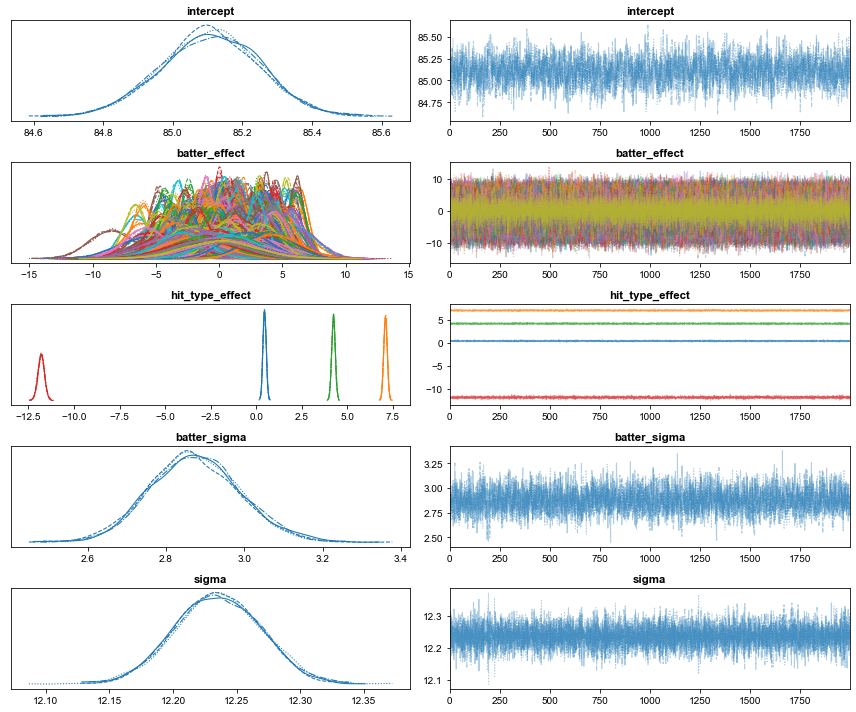

In [151]:
az.plot_trace(data=trace2)
plt.tight_layout()

In [152]:
with model:
    pm.sample_posterior_predictive(trace2,extend_inferencedata=True)


Sampling: [y]


In [154]:
trace2.posterior_predictive

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 2000, observation: 65802)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * observation  (observation) int64 0 1 2 3 4 ... 73370 73371 73372 73373 73374
Data variables:
    y            (chain, draw, observation) float64 76.57 73.3 ... 76.52 105.8
Attributes:
    created_at:                 2022-11-09T16:41:26.680520
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<AxesSubplot:xlabel='y / y'>

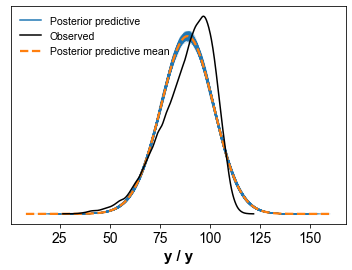

In [157]:
az.plot_ppc(trace2,num_pp_samples=1000)

Clearly we need to improve this but we are on the right track. 